### aim: recreate corinne's ferret c14 code in python

Notes here: https://satin-mascara-327.notion.site/Analysing-14C-079ef1a8ccb24e8f86c714d53d865f8c


Original script in ferretscript.yaml
- I think the problem with the timestamp was that it's from 1978-2042, not 1950-2014 (end)




In [11]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


Define data files

In [13]:
tmeshf = './corinneData/mesh_mask_v2.3.nc'
C14d_qtr_c14f = './corinneData/C14d_1950_2014_qtr_c14.nc'
C14d_Cflxf = './corinneData/C14d_1950_2014_Cflx.nc'

C14c_qtr_c14f = './corinneData/C14c_1950_2014_qtr_c14.nc'
C14c_Cflxf = './corinneData/C14c_1950_2014_Cflx.nc'
dc14dzf = './corinneData/dc14dz.nc'

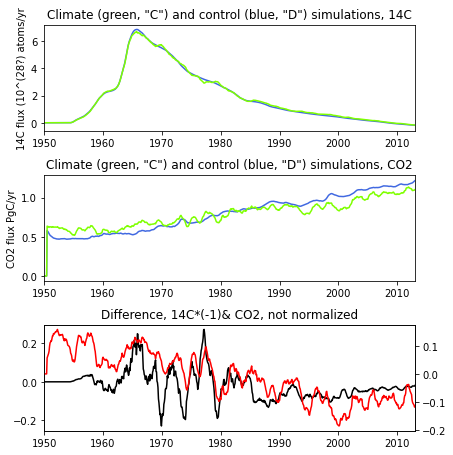

In [14]:
#### ------ A) load data
tmesh = xr.open_dataset(tmeshf)
#climate run
C14d_qtr_c14 = xr.open_dataset(C14d_qtr_c14f)
C14d_Cflx = xr.open_dataset(C14d_Cflxf)
#control run 
C14c_qtr_c14 = xr.open_dataset(C14c_qtr_c14f)
C14c_Cflx = xr.open_dataset(C14c_Cflxf)
#vertical gradient:
dc14dz  = xr.open_dataset(dc14dzf)

#### -------- B) get areas/grid variables
tmask = tmesh.tmask[0,0,:,:] 
area = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
tarea = np.nansum(area)
vol = area * tmesh.e3t_0[0,0]

##### ------ C) "regridding", ie fix the timestamp
times = pd.date_range("1950/01/01","2014/12/01",freq='MS')

qtrnewt_C = C14c_qtr_c14.qtr_c14 * tmask.values
qtrnewt_C['time_counter'] = times
cflxnewt_C = C14c_Cflx.Cflx * tmask.values
cflxnewt_C['time_counter'] = times

qtrnewt_D = C14d_qtr_c14.qtr_c14 * tmask.values
qtrnewt_C['time_counter'] = times
cflxnewt_D = C14d_Cflx.Cflx * tmask.values
cflxnewt_C['time_counter'] = times


##### ------ D) fluxes
### QQ why volume/10, why not area, wouldn't it be same?
### QQ why these units?/conversion factors?
qtrflx_C = qtrnewt_C * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_C = cflxnewt_C *area.values*3.156e7 
qtrflx_D = qtrnewt_D * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_D = cflxnewt_D *area.values*3.156e7 


fact = 0.8
fig, axs = plt.subplots(3,1, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


qtrflx_mn_C = qtrflx_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
qtrflx_mn_D = qtrflx_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_C, color = 'royalblue')
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_D, color = 'chartreuse')


cflxint_mn_C = cflxint_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 
cflxint_mn_D = cflxint_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 

axs[1].plot(qtrflx_C.time_counter, cflxint_mn_C, color = 'royalblue')
axs[1].plot(qtrflx_C.time_counter, cflxint_mn_D, color = 'chartreuse')

ax3 = axs[2]
ax3b = ax3.twinx()
ax3.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1, color = 'k')
ax3b.plot(qtrflx_C.time_counter, cflxint_mn_D.values-cflxint_mn_C.values, color = 'r')

axs[0].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
axs[1].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax3.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax3b.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))

axs[0].set_title('Climate (green, "C") and control (blue, "D") simulations, 14C')
axs[1].set_title('Climate (green, "C") and control (blue, "D") simulations, CO2')
axs[2].set_title('Difference, 14C*(-1)& CO2, not normalized')

axs[0].set_ylabel('14C flux (10^(28?) atoms/yr')
axs[1].set_ylabel('CO2 flux PgC/yr')

plt.tight_layout()
plt.show()

## with my data, exploring why it doesn't work

In [15]:
tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
C14d_qtr_c14f = './GCBdata/GEC1_1940_2022_qtrB14b.nc'   ##static
C14d_Cflxf = './GCBdata/GEC1_1940_2022_Cflx.nc' ###static

C14c_qtr_c14f = './GCBdata/GEA1_1940_2022_qtrB14b.nc'
C14c_Cflxf = './GCBdata/GEA1_1940_2022_Cflx.nc'
dc14dzf = './corinneData/dc14dz.nc'

<xarray.DataArray 'time_counter' (time_counter: 996)>
array([cftime.DatetimeNoLeap(1940, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1940, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1940, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2022, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2022, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2022, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    time_centered  (time_counter) object ...
  * time_counter   (time_counter) object 1940-01-16 12:00:00 ... 2022-12-16 1...
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time axis
    time_origin:    1950-01-01 00:00:00
    bounds:         time_counter_bounds


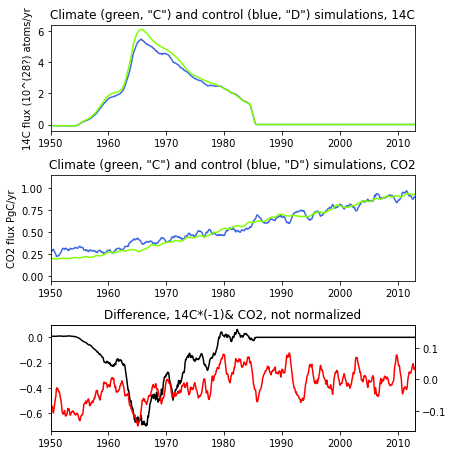

In [16]:
#### ------ A) load data
tmesh = xr.open_dataset(tmeshf)
#climate run
C14d_qtr_c14 = xr.open_dataset(C14d_qtr_c14f)
C14d_Cflx = xr.open_dataset(C14d_Cflxf)
#control run 
C14c_qtr_c14 = xr.open_dataset(C14c_qtr_c14f)
C14c_Cflx = xr.open_dataset(C14c_Cflxf)
#vertical gradient:
dc14dz  = xr.open_dataset(dc14dzf)

#### -------- B) get areas/grid variables
tmask = tmesh.tmask[0,0,:,:] 
area = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
tarea = np.nansum(area)
vol = area * tmesh.e3t_0[0,0]

##### ------ C) "regridding", ie fix the timestamp
times = pd.date_range("1940/01/01","2022/12/01",freq='MS')

qtrnewt_C = C14c_qtr_c14.qtrB14b * tmask.values
cflxnewt_C = C14c_Cflx.Cflx * tmask.values
qtrnewt_D = C14d_qtr_c14.qtrB14b * tmask.values
cflxnewt_D = C14d_Cflx.Cflx * tmask.values

print(qtrnewt_C['time_counter'])

qtrnewt_C['time_counter'] = times
qtrnewt_D['time_counter'] = times
cflxnewt_C['time_counter'] = times
cflxnewt_D['time_counter'] = times


##### ------ D) fluxes
### QQ why volume/10, why not area, wouldn't it be same?
### QQ why these units?/conversion factors?
qtrflx_C = qtrnewt_C * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_C = cflxnewt_C *area.values*3.156e7 
qtrflx_D = qtrnewt_D * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_D = cflxnewt_D *area.values*3.156e7 


fact = 0.8
fig, axs = plt.subplots(3,1, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


qtrflx_mn_C = qtrflx_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
qtrflx_mn_D = qtrflx_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_C, color = 'royalblue')
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_D, color = 'chartreuse')


cflxint_mn_C = cflxint_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 
cflxint_mn_D = cflxint_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 

axs[1].plot(qtrflx_C.time_counter, cflxint_mn_C, color = 'royalblue')
axs[1].plot(qtrflx_C.time_counter, cflxint_mn_D, color = 'chartreuse')

ax3 = axs[2]
ax3b = ax3.twinx()
ax3.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1, color = 'k')
ax3b.plot(qtrflx_C.time_counter, cflxint_mn_D.values-cflxint_mn_C.values, color = 'r')

axs[0].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
axs[1].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax3.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax3b.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))

axs[0].set_title('Climate (green, "C") and control (blue, "D") simulations, 14C')
axs[1].set_title('Climate (green, "C") and control (blue, "D") simulations, CO2')
axs[2].set_title('Difference, 14C*(-1)& CO2, not normalized')

axs[0].set_ylabel('14C flux (10^(28?) atoms/yr')
axs[1].set_ylabel('CO2 flux PgC/yr')

plt.tight_layout()
plt.show()

### after 1985 hardcode problem fixed (see kanban)

In [17]:
tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
C14d_qtr_c14f = './C405data/C4C5_1940_2022_qtrB14b.nc'   ##static
C14d_Cflxf = './C405data/C4C5_1940_2022_Cflx.nc' ###static

C14c_qtr_c14f = './C405data/C405_1940_2022_qtrB14b.nc'
C14c_Cflxf = './C405data/C405_1940_2022_Cflx.nc'
dc14dzf = './corinneData/dc14dz.nc'

<xarray.DataArray 'time_counter' (time_counter: 996)>
array([cftime.DatetimeNoLeap(1940, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1940, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1940, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2022, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2022, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2022, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    time_centered  (time_counter) object ...
  * time_counter   (time_counter) object 1940-01-16 12:00:00 ... 2022-12-16 1...
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time axis
    time_origin:    1950-01-01 00:00:00
    bounds:         time_counter_bounds


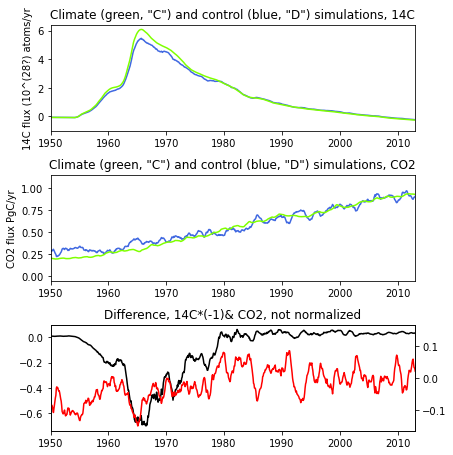

In [18]:
#### ------ A) load data
tmesh = xr.open_dataset(tmeshf)
#climate run
C14d_qtr_c14 = xr.open_dataset(C14d_qtr_c14f)
C14d_Cflx = xr.open_dataset(C14d_Cflxf)
#control run 
C14c_qtr_c14 = xr.open_dataset(C14c_qtr_c14f)
C14c_Cflx = xr.open_dataset(C14c_Cflxf)
#vertical gradient:
dc14dz  = xr.open_dataset(dc14dzf)

#### -------- B) get areas/grid variables
tmask = tmesh.tmask[0,0,:,:] 
area = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
tarea = np.nansum(area)
vol = area * tmesh.e3t_0[0,0]

##### ------ C) "regridding", ie fix the timestamp
times = pd.date_range("1940/01/01","2022/12/01",freq='MS')

qtrnewt_C = C14c_qtr_c14.qtrB14b * tmask.values
cflxnewt_C = C14c_Cflx.Cflx * tmask.values
qtrnewt_D = C14d_qtr_c14.qtrB14b * tmask.values
cflxnewt_D = C14d_Cflx.Cflx * tmask.values

print(qtrnewt_C['time_counter'])

qtrnewt_C['time_counter'] = times
qtrnewt_D['time_counter'] = times
cflxnewt_C['time_counter'] = times
cflxnewt_D['time_counter'] = times


##### ------ D) fluxes
### QQ why volume/10, why not area, wouldn't it be same?
### QQ why these units?/conversion factors?
qtrflx_C = qtrnewt_C * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_C = cflxnewt_C *area.values*3.156e7 
qtrflx_D = qtrnewt_D * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_D = cflxnewt_D *area.values*3.156e7 


fact = 0.8
fig, axs = plt.subplots(3,1, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


qtrflx_mn_C = qtrflx_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
qtrflx_mn_D = qtrflx_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_C, color = 'royalblue')
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_D, color = 'chartreuse')


cflxint_mn_C = cflxint_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 
cflxint_mn_D = cflxint_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 

axs[1].plot(qtrflx_C.time_counter, cflxint_mn_C, color = 'royalblue')
axs[1].plot(qtrflx_C.time_counter, cflxint_mn_D, color = 'chartreuse')

ax3 = axs[2]
ax3b = ax3.twinx()
ax3.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1, color = 'k')
ax3b.plot(qtrflx_C.time_counter, cflxint_mn_D.values-cflxint_mn_C.values, color = 'r')

axs[0].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
axs[1].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax3.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax3b.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))

axs[0].set_title('Climate (green, "C") and control (blue, "D") simulations, 14C')
axs[1].set_title('Climate (green, "C") and control (blue, "D") simulations, CO2')
axs[2].set_title('Difference, 14C*(-1)& CO2, not normalized')

axs[0].set_ylabel('14C flux (10^(28?) atoms/yr')
axs[1].set_ylabel('CO2 flux PgC/yr')

plt.tight_layout()
plt.show()

In [19]:
print('compute complete')

compute complete
